In [1]:
from pystac_client import Client
from odc.stac import load
import xarray as xr
import numpy as np
import odc.geo # noqa
from xarray import DataArray, Dataset
from odc.geo.geom import Geometry
from odc.geo.xr import mask
import geopandas as gpd
import pandas as pd

In [2]:
site = "Malampa_South"

In [3]:
# client = Client.open("https://stac.digitalearthpacific.org")

catalog = "https://stac.digitalearthpacific.org"
collection = "dep_s2_mangroves"

In [4]:
bbox = gpd.read_file("priority_1_sites/"f"{site}.geojson")
bbox = bbox.to_crs("EPSG:4326")
bounds_df = bbox.bounds
# bbox = Geometry(bbox.geometry.values[0], crs=bbox.crs)

In [5]:
bounds_df

,minx,miny,maxx,maxy
0,167.393292,-16.679706,167.98351,-16.366688


In [6]:
values_array = bounds_df.values
values_array

array([[167.39329175, -16.67970649, 167.98350989, -16.36668772]])

In [7]:
flat_array = values_array.flatten()
flat_array

array([167.39329175, -16.67970649, 167.98350989, -16.36668772])

In [8]:
bbox_int_list = flat_array.tolist()
bbox_int_list

[167.39329174790393, -16.6797064912959, 167.98350989221956, -16.36668772164736]

In [9]:
bbox_tuple = tuple(bbox_int_list)
bbox_tuple

(167.39329174790393, -16.6797064912959, 167.98350989221956, -16.36668772164736)

In [10]:
# Get some seagrass data for the area
client = Client.open("https://stac.digitalearthpacific.org")
items = client.search(
    collections=collection,
    bbox=bbox_tuple
).item_collection()

print(f"Found {len(items)} items")

Found 8 items


In [11]:
bbox.explore()

In [12]:
items

In [13]:
# # Coordinates grabbed from Google Maps

# # bbox coords
# ll = (-16.544442,178.759840)
# ur = (-16.485047,178.827006)

# bbox = (ll[1], ll[0], ur[1], ur[0])

# # # Find STAC items
# # client = Client.open(catalog)
# # items = client.search(collections=[collection], bbox=bbox).items()
# # items = [i for i in items]

# # print(f"Found {len(items)} items")

In [14]:
config = {
    collection: {
        "assets": {
            "mangroves": {"data_type": "int16"}
        }
    }
}

data = load(items, bbox=bbox_tuple, bands=["mangroves"], stac_cfg=config)
data

<xarray.Dataset> Size: 380MB
Dimensions:      (y: 3613, x: 6571, time: 8)
Coordinates:
  * y            (y) float64 29kB -1.835e+06 -1.835e+06 ... -1.871e+06
  * x            (x) float64 53kB 1.936e+06 1.936e+06 ... 2.002e+06 2.002e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 64B 2017-01-01 2018-01-01 ... 2024-01-01
Data variables:
    mangroves    (time, y, x) int16 380MB 255 255 255 255 255 255 ... 0 0 0 0 0

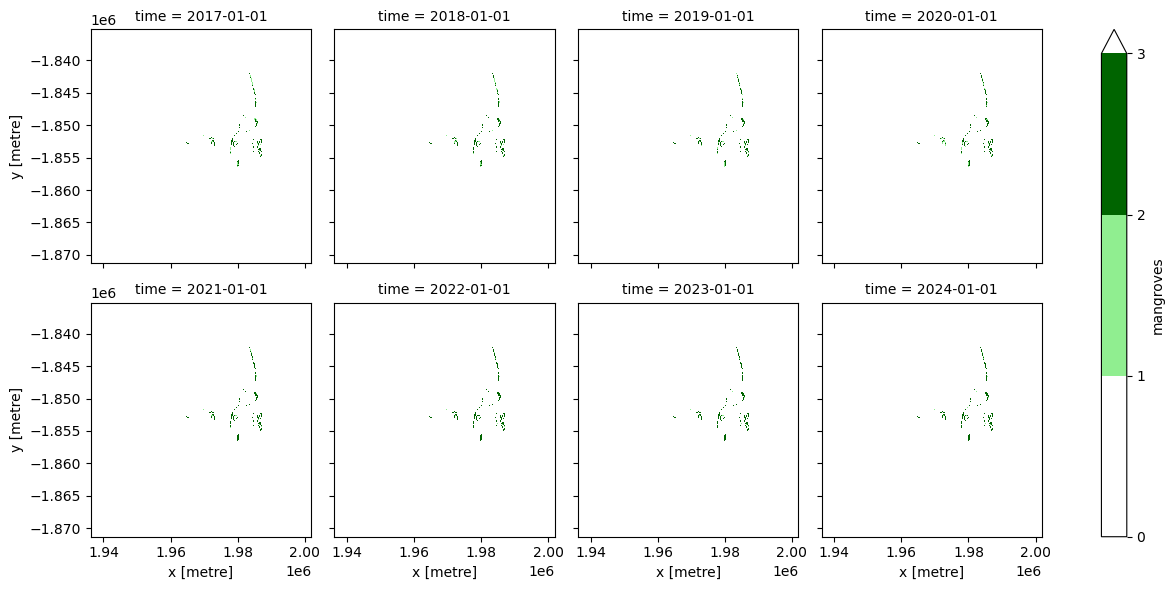

In [15]:
data.mangroves.plot.imshow(
    col="time",
    col_wrap=4,
    levels=[0, 1, 2, 3],
    colors=["white", "lightgreen", "darkgreen"],
)

In [16]:
# Define the values you want to count (0, 1, and 2)
values_to_count = [0, 1, 2]

# Initialize an empty DataArray to store the counts
count_array = xr.DataArray(
    np.zeros((len(data["time"]), len(values_to_count))),
    coords={"time": data["time"], "values": values_to_count},
    dims=["time", "values"],
)

# Loop through each value and count occurrences in each year
for time in data.time:
    year = time.values.astype("datetime64[Y]")
    one_year_data = data.sel(time=time)
    count = one_year_data.mangroves.groupby(one_year_data.mangroves).count()
    for i, v in enumerate(values_to_count):
        if v not in count.mangroves:
            # Add the missing count to the array
            count_array.loc[{"time": time, "values": v}] = 0
        else:
            # Add the count to the array
            val = count.sel(mangroves=v)
            count_array.loc[{"time": time, "values": v}] = val * 100 / 10000

# Rename the count variable
count_array = count_array.rename("count")
count_array

<xarray.DataArray 'count' (time: 8, values: 3)> Size: 192B
array([[35908.81,   159.06,   508.88],
       [35903.37,   135.97,   537.41],
       [35905.1 ,   137.17,   534.48],
       [35905.73,   145.82,   525.2 ],
       [35900.07,    71.86,   604.82],
       [35906.65,    41.46,   628.64],
       [35909.89,    55.87,   610.99],
       [35904.66,    65.88,   606.21]])
Coordinates:
  * time     (time) datetime64[ns] 64B 2017-01-01 2018-01-01 ... 2024-01-01
  * values   (values) int64 24B 0 1 2

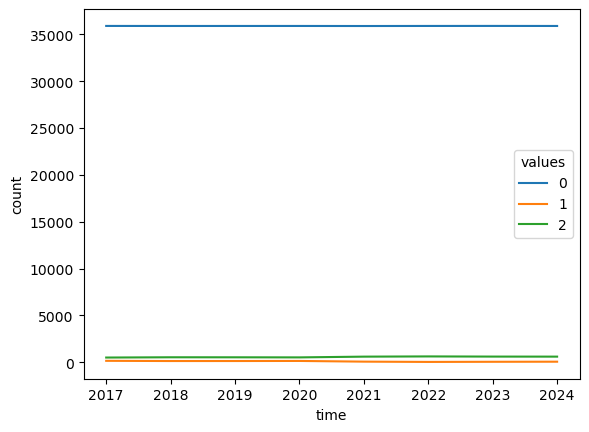

In [17]:
count_array.plot.line(x="time", hue="values")

In [18]:
count_ha = 0.01

dataframe = count_array.to_dataframe()
results_df = dataframe['count'].unstack(level='time')
x = 4
results_df.columns = results_df.columns.astype(str).str[:x]

dataframe['ha'] = dataframe['count'] * count_ha
dataframe

count        ha
time       values                    
2017-01-01 0       35908.81  359.0881
           1         159.06    1.5906
           2         508.88    5.0888
2018-01-01 0       35903.37  359.0337
           1         135.97    1.3597
           2         537.41    5.3741
2019-01-01 0       35905.10  359.0510
           1         137.17    1.3717
           2         534.48    5.3448
2020-01-01 0       35905.73  359.0573
           1         145.82    1.4582
           2         525.20    5.2520
2021-01-01 0       35900.07  359.0007
           1          71.86    0.7186
           2         604.82    6.0482
2022-01-01 0       35906.65  359.0665
           1          41.46    0.4146
           2         628.64    6.2864
2023-01-01 0       35909.89  359.0989
           1          55.87    0.5587
           2         610.99    6.1099
2024-01-01 0       35904.66  359.0466
           1          65.88    0.6588
           2         606.21    6.0621

In [19]:
# dataframe = count_array.to_dataframe()
# results_df = dataframe['count'].unstack(level='time')
# x = 4
# results_df.columns = results_df.columns.astype(str).str[:x]

In [20]:
class_mapping = {
    0: 'No mangroves',
    1: 'Low canopy cover',
    2: 'High canopy cover'
}

results_df = results_df.rename(index=class_mapping, level='values')

In [21]:
results_df = results_df.rename_axis(columns="Hectares over time")
results_df.index.name = None
results_df

Hectares over time,2017,2018,2019,2020,2021,2022,2023,2024
No mangroves,35908.81,35903.37,35905.10,35905.73,35900.07,35906.65,35909.89,35904.66
Low canopy cover,159.06,135.97,137.17,145.82,71.86,41.46,55.87,65.88
High canopy cover,508.88,537.41,534.48,525.20,604.82,628.64,610.99,606.21


In [22]:
# results_df.plot.line()

In [23]:
results_df.to_csv("change_detection/"f"{site}-area-cd.csv")

In [24]:
# for year in range(2018, 2023):
#     data.sel(time=str(year), method='nearest').mangroves.odc.write_cog(f"test_change_detection/mangroves_{year}.tif", overwrite=True)

In [25]:
# data.to_zarr("test.zarr")

In [26]:
for time in data.time:
    year = time.values.astype("datetime64[Y]")
    one_year_data = data.sel(time=time)
    # one_year_data.mangroves.odc.write_cog(f"mangroves_{year}.tif")

In [27]:
from matplotlib import colors

cd_classes = [
    [-9, "No data", "#FFFFFF", "transparent"],
    [-8, "High-density - High-density", "#007c69", "teal"],
    [-7, "High-density - Low-density", "#FFC91C", "orange"],
    [-6, "High-density - No mangroves", "#800600", "maroon"],
    [-5, "Low-density - High-density", "#00801E", "green"],
    [-4, "Low-density - Low-density", "#BBF2C6", "light green"],
    [-3, "Low-density - No-mangroves", "#FFF899", "yellow"],
    [-2, "No-mangroves - High-density", "#600087", "purple"],
    [-1, "No-mangroves - Low-density", "#A97EBD", "lavender"],
    [0, "No-mangroves - No-mangroves", "#E0E0E0", "grey"],
]

values_list = [c[0] for c in cd_classes]
cd_color_list = [c[2] for c in cd_classes]

cd_color_list = [cd[2] for cd in cd_classes]
bounds = values_list + [10]
cd_map = colors.ListedColormap(cd_color_list)
norm = colors.BoundaryNorm(bounds, cd_map.N)

# Do for loop

# Do variable t1 and t2 to replace code below

print("Mangrove extent changes")
change_2018_2024 = data.mangroves.sel(time="2018", method='nearest')*-3 - data.mangroves.sel(time="2024", method='nearest') 



Mangrove extent changes


In [28]:
import numpy as np
# Assuming my_raster is your xarray.DataArray

# 1. Define the old and new No Data values
OLD_NODATA = -1020
NEW_NODATA = -9

# 2. Use the xarray.DataArray.where() method to replace the value.
#    The `where` method keeps the values where the condition is True,
#    and replaces values where the condition is False with the specified value.

change_2018_2024 = change_2018_2024.where(
    change_2018_2024 != OLD_NODATA, # Keep all values that are NOT -1020
    NEW_NODATA               # Replace -1020 with -9
)

# 3. (Optional but recommended) Update the attributes if available
#    This ensures future tools/functions recognize the new No Data value.
if 'nodata' in change_2018_2024.attrs:
    change_2018_2024.attrs['nodata'] = NEW_NODATA
elif '_FillValue' in change_2018_2024.attrs:
    change_2018_2024.attrs['_FillValue'] = NEW_NODATA

print(f"No Data value -1020 has been changed to {NEW_NODATA}")

No Data value -1020 has been changed to -9


In [29]:
change_2018_2024

<xarray.DataArray 'mangroves' (y: 3613, x: 6571)> Size: 47MB
array([[-9, -9, -9, ...,  0,  0,  0],
       [-9, -9, -9, ...,  0,  0,  0],
       [-9, -9, -9, ...,  0,  0,  0],
       ...,
       [-9, -9, -9, ...,  0,  0,  0],
       [-9, -9, -9, ...,  0,  0,  0],
       [-9, -9, -9, ...,  0,  0,  0]], dtype=int16)
Coordinates:
  * y            (y) float64 29kB -1.835e+06 -1.835e+06 ... -1.871e+06
  * x            (x) float64 53kB 1.936e+06 1.936e+06 ... 2.002e+06 2.002e+06
    spatial_ref  int32 4B 3832

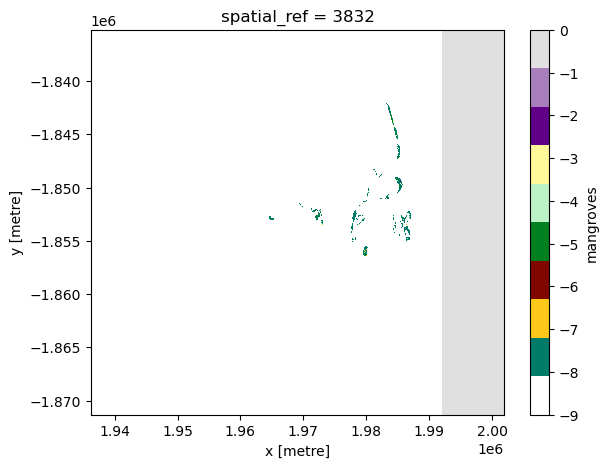

In [30]:
change_2018_2024.plot(cmap=cd_map, size=5)

In [31]:
change_2018_2024.odc.write_cog("change_detection/change_2018_2024.tif", overwrite=True)


PosixPath('change_detection/change_2018_2024.tif')